In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics import AUROC
import torch.nn.functional as F
from scipy import stats
from sklearn.linear_model import LinearRegression

from func2graph import models, tools, baselines, data

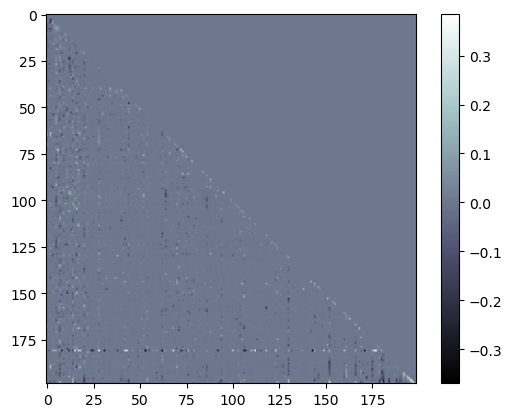

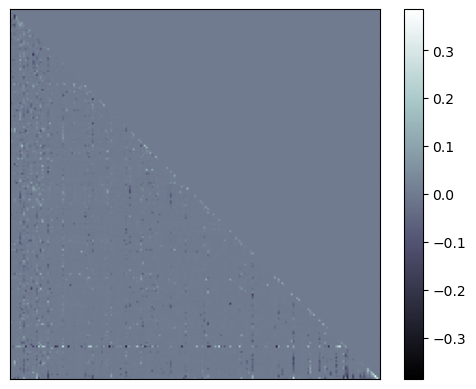

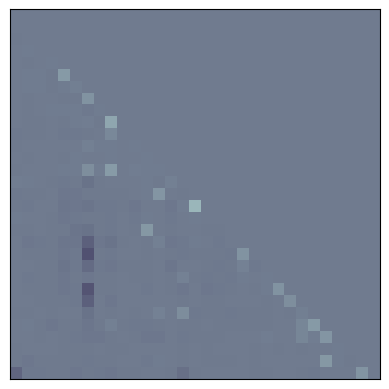

In [36]:
TT = np.load("./TT.npy")

plt.imshow(TT, cmap="bone")
plt.colorbar()
plt.show()

# make all elements except off-1 diagonal *0.85
for i in range(0, TT.shape[0]):
    for j in range(0, TT.shape[1]):
        if i != j+1:
            TT[i,j] = TT[i,j] * 0.9

abs_max = np.max(np.abs(TT))
vmin = -abs_max
vmax = abs_max
plt.imshow(TT, cmap="bone", vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.imshow(TT[80:111, 80:111], cmap='bone', vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.show()

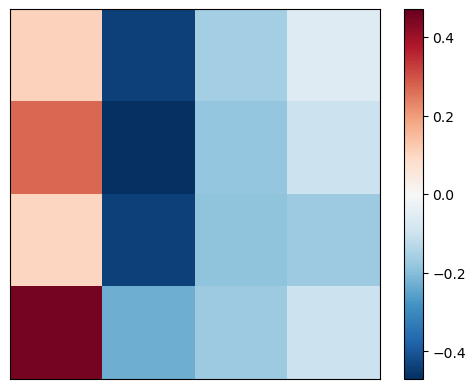

In [31]:
GT_prob_connectivity = np.load('..//data/Mouse_Local_Connectivity/GT_prob_connectivity.npy')
GT_strength_connectivity = np.load('..//data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')

max_abs = np.max(np.abs(GT_strength_connectivity))
plt.imshow(GT_strength_connectivity, cmap='RdBu_r', interpolation='nearest', vmin=-max_abs, vmax=max_abs)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

### Simulation Data

In [28]:
strength_matrix = np.zeros((4, 4))
strength_matrix[0, 0] = 0.3
strength_matrix[1, 0] = 0.59
strength_matrix[2, 0] = 0.88
strength_matrix[3, 0] = 1.89

strength_matrix[0, 1] = -0.43
strength_matrix[1, 1] = -0.53
strength_matrix[2, 1] = -0.60
strength_matrix[3, 1] = -0.44

strength_matrix[0, 2] = -0.31
strength_matrix[1, 2] = -0.43
strength_matrix[2, 2] = -0.43
strength_matrix[3, 2] = -0.79

strength_matrix[0, 3] = -0.25
strength_matrix[1, 3] = -0.30
strength_matrix[2, 3] = -0.42
strength_matrix[3, 3] = -0.33


cutoff_matrix = np.zeros((4, 4))
cutoff_matrix[0, 0] = 13/229
cutoff_matrix[1, 0] = 22/53
cutoff_matrix[2, 0] = 20/67
cutoff_matrix[3, 0] = 11/68

cutoff_matrix[0, 1] = 18/52
cutoff_matrix[1, 1] = 45/114
cutoff_matrix[2, 1] = 8/88
cutoff_matrix[3, 1] = 0/54

cutoff_matrix[0, 2] = 13/56
cutoff_matrix[1, 2] = 15/84
cutoff_matrix[2, 2] = 8/154
cutoff_matrix[3, 2] = 25/84

cutoff_matrix[0, 3] = 3/62
cutoff_matrix[1, 3] = 1/54
cutoff_matrix[2, 3] = 12/87
cutoff_matrix[3, 3] = 2/209

In [18]:
neuron_num = 200   #####################
total_time = 30000

data_random_seed=42 ######################

weight_type="cell_type"

simulator = data.data_simulator(
    neuron_num=neuron_num, 
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
)

nn_strength_GT = simulator.W_ij
nn_strength_GT = nn_strength_GT.numpy()

0.4553686830858257


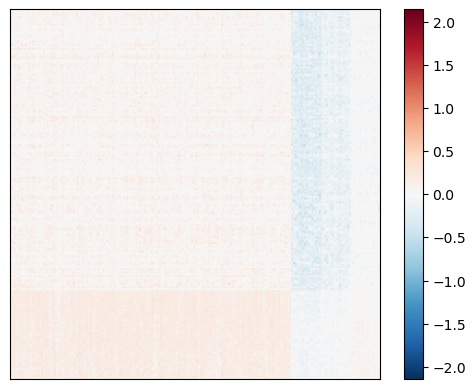

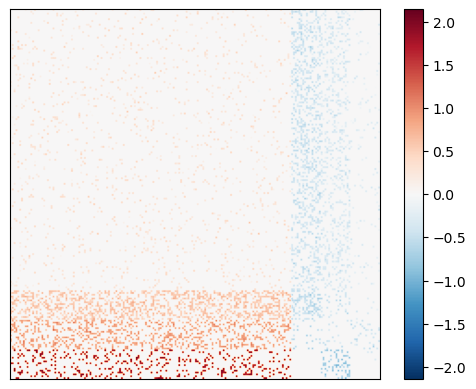

In [37]:
nn_strength_W = np.load('../output/11_13_sim_data/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_42_32_128_128_0_1_1_200_64_0_5e-05_lookup_table_spatial_temporal_1_none_cycle_0.0/Estimated_W_42.npy')

reg = LinearRegression().fit(nn_strength_W.reshape(-1, 1), nn_strength_GT.reshape(-1, 1))
nn_strength_W = reg.predict(nn_strength_W.reshape(-1, 1))
nn_strength_W = nn_strength_W.reshape((neuron_num, neuron_num))

corr = stats.pearsonr(nn_strength_GT.reshape(-1), nn_strength_W.reshape(-1))[0]
print(corr)

max_abs = np.max(np.abs(nn_strength_GT))
plt.imshow(nn_strength_W, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
# plt.xlabel("76%:'EC', 8%:'Pvalb', 8%:'Sst', 8%:'Vip'")
# plt.suptitle("Estimated N*N Connectivity Strength Matrix", fontsize=14)
# plt.title("correlation = 0.456")
plt.xticks([])
plt.yticks([])
plt.show()

max_abs = np.max(np.abs(nn_strength_GT))
plt.imshow(nn_strength_GT, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

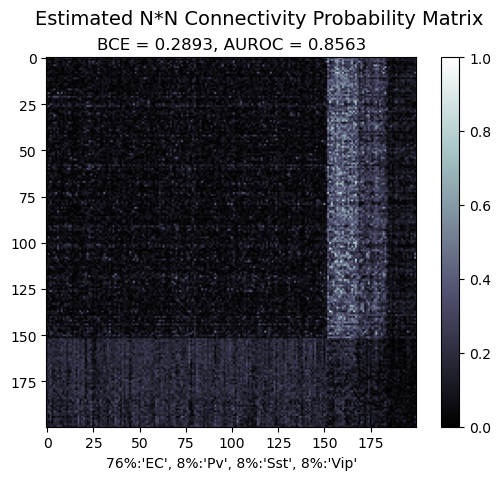

In [18]:
nn_prob_W = np.abs(nn_strength_W)
nn_prob_W = (nn_prob_W - np.min(nn_prob_W)) / (np.max(nn_prob_W) - np.min(nn_prob_W))

plt.imshow(nn_prob_W, cmap='bone')
plt.colorbar()
plt.xlabel("76%:'EC', 8%:'Pvalb', 8%:'Sst', 8%:'Vip'")
plt.suptitle("Estimated N*N Connectivity Probability Matrix", fontsize=14)
plt.title("BCE = 0.2893, AUROC = 0.8563")
plt.show()

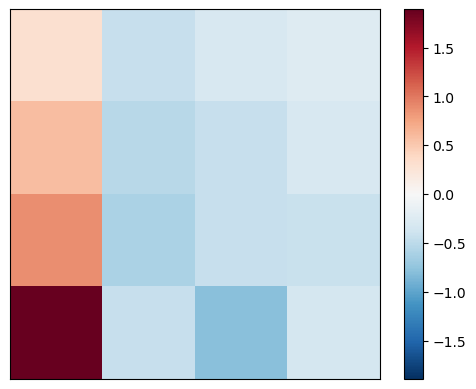

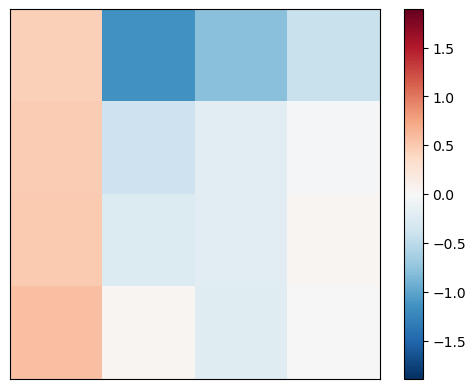

In [32]:
max_abs = np.max(np.abs(strength_matrix))
plt.imshow(strength_matrix, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
# plt.title("GT K*K Connectivity Strength Matrix", fontsize=14)
# plt.xlabel("{0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}")
plt.xticks([])
plt.yticks([])
plt.show()

kk_strength_W = np.load('../output/11_13_sim_data/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_42_32_128_128_0_1_1_200_64_0_5e-05_lookup_table_spatial_temporal_1_none_cycle_0.0/cell_type_level_W_42.npy')
reg = LinearRegression().fit(kk_strength_W.reshape(-1, 1), strength_matrix.reshape(-1, 1))
kk_strength_W = reg.predict(kk_strength_W.reshape(-1, 1))
kk_strength_W = kk_strength_W.reshape((4, 4))

max_abs = np.max(np.abs(strength_matrix))
plt.imshow(kk_strength_W, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
# plt.suptitle("Estimated K*K Connectivity Strength Matrix", fontsize=14)
# plt.title("correlation = 0.670")
# plt.xlabel("{0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}")
plt.xticks([])
plt.yticks([])
plt.show()

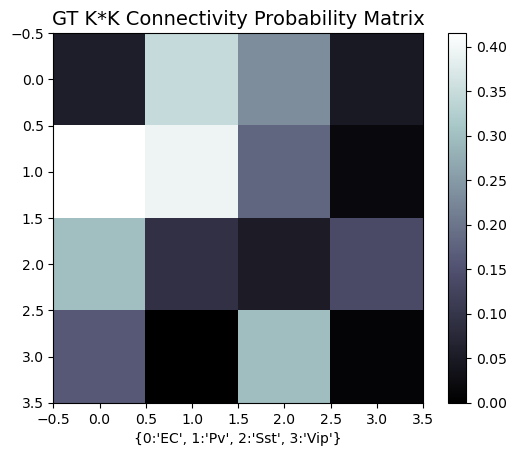

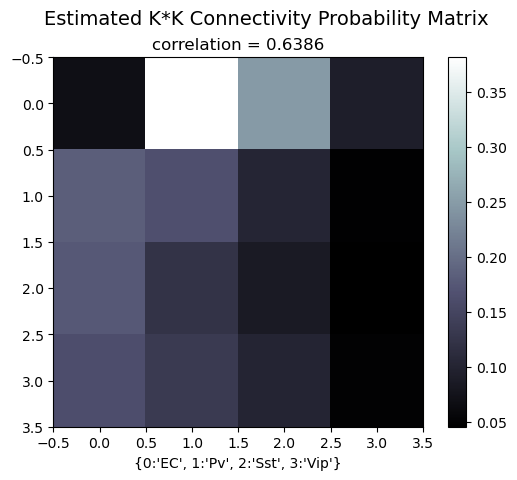

In [26]:
neuron_num = 200
cell_type_count = {'EC':int(neuron_num*0.76), 'Pvalb':int(neuron_num*0.08), 'Sst':int(neuron_num*0.08), 'Vip':int(neuron_num*0.08)}
cell_type_id2cell_type = {0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}

kk_prob_W = tools.calculate_cell_type_level_connectivity_matrix(
    connectivity_matrix_new=nn_prob_W,
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

corr = np.corrcoef(kk_prob_W.flatten(), cutoff_matrix.flatten())[0, 1]

plt.imshow(cutoff_matrix, cmap='bone')
plt.colorbar()
plt.title("GT K*K Connectivity Probability Matrix", fontsize=14)
plt.xlabel("{0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}")
plt.show()

plt.imshow(kk_prob_W, cmap='bone')
plt.colorbar()
plt.suptitle("Estimated K*K Connectivity Probability Matrix", fontsize=14)
plt.title("correlation = {:.4f}".format(corr))
plt.xlabel("{0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}")
plt.show()

### Real Mouse Data

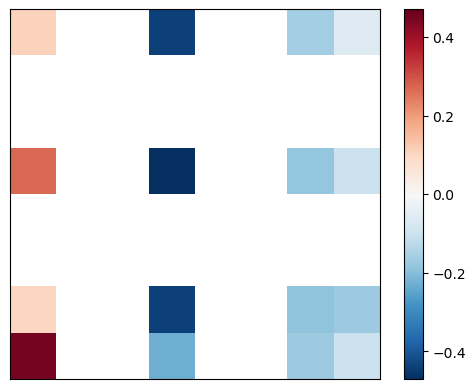

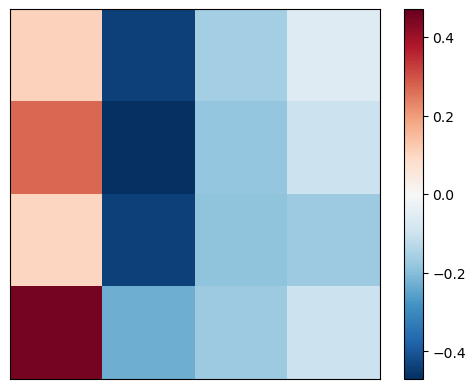

correlation = 0.7769
spearman correlation = 0.7178


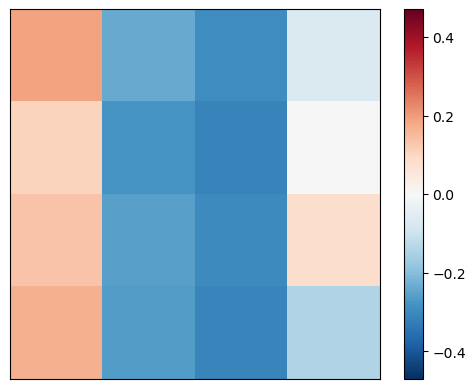

In [36]:
cell_type2id = {'EC': 0, 'IN': 1, 'Lamp5': 2, 'Pvalb': 3, 'Serpinf1': 4, 'Sncg': 5, 'Sst': 6, 'Vip': 7}
cell_type = ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']
cell_type_2 = ['EC', 'Pvalb', 'Sst', 'Vip']

GT_strength_connectivity = np.zeros((8, 8))
GT_strength_connectivity[:] = np.nan

GT_strength_connectivity[cell_type2id['EC']][cell_type2id['EC']] = 0.11
GT_strength_connectivity[cell_type2id['Pvalb']][cell_type2id['EC']] = 0.27
GT_strength_connectivity[cell_type2id['Sst']][cell_type2id['EC']]= 0.1
GT_strength_connectivity[cell_type2id['Vip']][cell_type2id['EC']] = 0.45

GT_strength_connectivity[cell_type2id['EC']][cell_type2id['Pvalb']] = -0.44
GT_strength_connectivity[cell_type2id['Pvalb']][cell_type2id['Pvalb']] = -0.47
GT_strength_connectivity[cell_type2id['Sst']][cell_type2id['Pvalb']] = -0.44
GT_strength_connectivity[cell_type2id['Vip']][cell_type2id['Pvalb']] = -0.23

GT_strength_connectivity[cell_type2id['EC']][cell_type2id['Sst']] = -0.16
GT_strength_connectivity[cell_type2id['Pvalb']][cell_type2id['Sst']] = -0.18
GT_strength_connectivity[cell_type2id['Sst']][cell_type2id['Sst']] = -0.19
GT_strength_connectivity[cell_type2id['Vip']][cell_type2id['Sst']] = -0.17

GT_strength_connectivity[cell_type2id['EC']][cell_type2id['Vip']] = -0.06
GT_strength_connectivity[cell_type2id['Pvalb']][cell_type2id['Vip']] = -0.10
GT_strength_connectivity[cell_type2id['Sst']][cell_type2id['Vip']] = -0.17
GT_strength_connectivity[cell_type2id['Vip']][cell_type2id['Vip']] = -0.10

mask = ~np.isnan(GT_strength_connectivity)

max_abs = 0.47
plt.imshow(GT_strength_connectivity, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
# plt.xticks(np.arange(len(cell_type)), cell_type, rotation=45)
# plt.yticks(np.arange(len(cell_type)), cell_type)
plt.colorbar()
# plt.title("GT K*K Connectivity Strength Matrix", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(GT_strength_connectivity[mask].reshape(4,4), cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xticks([])
plt.yticks([])
# plt.xticks(np.arange(len(cell_type_2)), cell_type_2)
# plt.yticks(np.arange(len(cell_type_2)), cell_type_2)
plt.show()


# Estimation ---------------------------------------------------------------
estimated_strength_connectivity = np.load('./plot/avg_k_k_4.npy')
reg = LinearRegression().fit(estimated_strength_connectivity[mask].reshape(-1, 1), GT_strength_connectivity[mask].reshape(-1, 1))
estimated_strength_connectivity = reg.predict(estimated_strength_connectivity[mask].reshape(-1, 1))
estimated_strength_connectivity = estimated_strength_connectivity.reshape(4, 4)


corr = np.corrcoef(estimated_strength_connectivity.flatten(), GT_strength_connectivity[mask].flatten())[0, 1]
spearman_corr = stats.spearmanr(estimated_strength_connectivity.flatten(), GT_strength_connectivity[mask].flatten())[0]
print("correlation = {:.4f}".format(corr))
print("spearman correlation = {:.4f}".format(spearman_corr))

max_abs = 0.47
plt.imshow(estimated_strength_connectivity, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xticks([])
plt.yticks([])
# plt.title("correlation = 0.7769")
# plt.xticks(np.arange(len(cell_type_2)), cell_type_2)
# plt.yticks(np.arange(len(cell_type_2)), cell_type_2)
plt.show()

prob pearson corr:  0.298677373909614
prob spearman corr:  0.3941176470588235


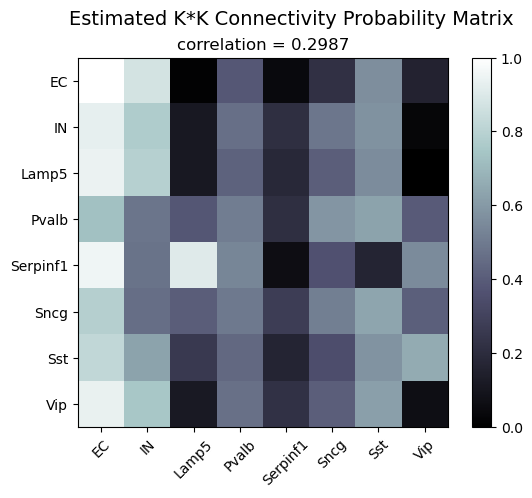

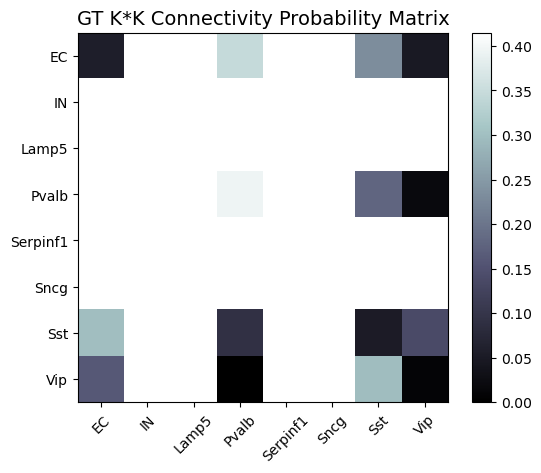

In [8]:
GT_prob_connectivity = np.zeros((8, 8))
GT_prob_connectivity[:] = np.nan

# replace ground truth prob connectivity with GT prob connectivity
GT_prob_connectivity[cell_type2id['EC']][cell_type2id['EC']] = 13/229
GT_prob_connectivity[cell_type2id['Pvalb']][cell_type2id['EC']] = 22/53
GT_prob_connectivity[cell_type2id['Sst']][cell_type2id['EC']]= 20/67
GT_prob_connectivity[cell_type2id['Vip']][cell_type2id['EC']] = 11/68

GT_prob_connectivity[cell_type2id['EC']][cell_type2id['Pvalb']] = 18/52
GT_prob_connectivity[cell_type2id['Pvalb']][cell_type2id['Pvalb']] = 45/114
GT_prob_connectivity[cell_type2id['Sst']][cell_type2id['Pvalb']] = 8/88
GT_prob_connectivity[cell_type2id['Vip']][cell_type2id['Pvalb']] = 0/54

GT_prob_connectivity[cell_type2id['EC']][cell_type2id['Sst']] = 13/56
GT_prob_connectivity[cell_type2id['Pvalb']][cell_type2id['Sst']] = 15/84
GT_prob_connectivity[cell_type2id['Sst']][cell_type2id['Sst']] = 8/154
GT_prob_connectivity[cell_type2id['Vip']][cell_type2id['Sst']] = 25/84

GT_prob_connectivity[cell_type2id['EC']][cell_type2id['Vip']] = 3/62
GT_prob_connectivity[cell_type2id['Pvalb']][cell_type2id['Vip']] = 1/54
GT_prob_connectivity[cell_type2id['Sst']][cell_type2id['Vip']] = 12/87
GT_prob_connectivity[cell_type2id['Vip']][cell_type2id['Vip']] = 2/209


# normalize to zero mean and std 1
# prob_prediction = estimated_strength_connectivity
estimated_strength_connectivity = np.load('./plot/avg_k_k_4.npy')
prob_prediction = (estimated_strength_connectivity - np.mean(estimated_strength_connectivity))/np.std(estimated_strength_connectivity)

# min-max normalization on estimated W
prob_prediction = np.abs(prob_prediction)
prob_prediction = (prob_prediction - np.min(prob_prediction)) / (np.max(prob_prediction) - np.min(prob_prediction))
prob_pearson_corr = np.corrcoef(prob_prediction[mask].flatten(), GT_prob_connectivity[mask].flatten())[0, 1]
print('prob pearson corr: ', prob_pearson_corr)
prob_spearman_corr = stats.spearmanr(prob_prediction[mask].flatten(), GT_prob_connectivity[mask].flatten())[0]
print('prob spearman corr: ', prob_spearman_corr)


# plot
plt.imshow(prob_prediction, cmap='bone')
plt.xticks(np.arange(len(cell_type)), cell_type, rotation=45)
plt.yticks(np.arange(len(cell_type)), cell_type)
plt.colorbar()
plt.suptitle("Estimated K*K Connectivity Probability Matrix", fontsize=14)
plt.title("correlation = {:.4f}".format(prob_pearson_corr))
plt.show()

plt.imshow(GT_prob_connectivity, cmap='bone')
plt.xticks(np.arange(len(cell_type)), cell_type, rotation=45)
plt.yticks(np.arange(len(cell_type)), cell_type)
plt.colorbar()
plt.title("GT K*K Connectivity Probability Matrix", fontsize=14)
plt.show()